## Forecasting for Monitor

This notebook walks through building charts used in the Monitor application.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

In [384]:
import os
import logging
import pandas as pd
from pandas import Grouper
from pygam import LinearGAM, s
import matplotlib
import matplotlib.pyplot as plt
import pytz
import datetime
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

try:
    from django.db import models
    from traffic_monitor.models.model_logentry import LogEntry
    

except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper, ColorBar, FixedTicker, NumeralTickFormatter

from bokeh.models import HoverTool, WheelZoomTool, ResetTool
from bokeh.models import Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import brewer, RdYlGn11
from bokeh.embed import components
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, HTMLTemplateFormatter, TableColumn, DataTable, HoverTool, \
    DatetimeTickFormatter, Line, FactorRange
from bokeh.plotting import figure
from django.http import JsonResponse
output_notebook()

Loading BokehJS ...

In [385]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

In [386]:
rs = LogEntry.objects.all().values()
raw_df = pd.DataFrame(rs)

# convert to local TZ and then remove the timezone from the time_stamp
raw_df['time_stamp'] = raw_df['time_stamp'].dt.tz_convert(pytz.timezone('US/Mountain')).dt.tz_localize(None)

# save the categories
categories = raw_df['class_name'].unique()

# make columns categorical and remove multi_index
raw_df = raw_df.pivot_table(index=['time_stamp'], columns='class_name', values='count', fill_value=0)
raw_df.columns = raw_df.columns.get_level_values(0).values

raw_df['weekday'] = pd.Series(raw_df.index).apply(lambda s: s.weekday()).values
raw_df['month'] = pd.Series(raw_df.index).apply(lambda s: s.month).values
raw_df['day'] = pd.Series(raw_df.index).apply(lambda s: s.day).values
raw_df['year'] = pd.Series(raw_df.index).apply(lambda s: s.year).values
raw_df['qtr_hour'] = pd.Series(raw_df.index).apply(lambda s : int(s.minute / 15) * 15).values
raw_df['hour'] = pd.Series(raw_df.index).apply(lambda s: s.hour).values
raw_df['minute'] = pd.Series(raw_df.index).apply(lambda s: s.minute).values
raw_df['day_minute'] = pd.Series(raw_df.index).apply(lambda s :(s.hour * 60 + s.minute)).values
raw_df['day_minute_qtr_hour'] = pd.Series(raw_df.day_minute).apply(lambda s : int(s/60) * 60 + int(s % 60 / 15) * 15).values
raw_df['week_minute'] = pd.Series(raw_df.index).apply(lambda s :(s.weekday() * 24*60) + (s.hour * 60) + s.minute).values
raw_df['week_minute_qtr_hour'] = pd.Series(raw_df.week_minute).apply(lambda s : int(s/60) * 60 + int(s % 60 / 15) * 15).values
raw_df['midnight'] = pd.Series(raw_df.index).apply(lambda s: True if s.hour == 0 and int(s.minute / 15) == 0 else False).values
raw_df.head()

,bicycle,bus,car,dog,motorcycle,person,traffic light,truck,umbrella,weekday,...,day,year,qtr_hour,hour,minute,day_minute,day_minute_qtr_hour,week_minute,week_minute_qtr_hour,midnight
time_stamp,,,,,,,,,,,,,,,,,,,,,
2020-08-28 13:59:46.557975,0.0,0.000,3.308,0.0,0.0,0.231,0.0,0.0,0.0,4,...,28,2020,45,13,59,839,825,6599,6585,False
2020-08-28 14:00:46.711236,0.0,0.000,3.417,0.0,0.0,0.833,0.0,0.0,0.0,4,...,28,2020,0,14,0,840,840,6600,6600,False
2020-08-28 14:01:46.725153,0.0,0.000,3.000,0.0,0.0,0.333,0.0,0.0,0.0,4,...,28,2020,0,14,1,841,840,6601,6600,False
2020-08-28 14:02:46.745504,0.0,0.083,2.333,0.0,0.0,0.083,0.0,0.0,0.0,4,...,28,2020,0,14,2,842,840,6602,6600,False
2020-08-28 14:03:46.762111,0.0,0.083,4.667,0.0,0.0,0.333,0.0,0.0,0.0,4,...,28,2020,0,14,3,843,840,6603,6600,False


In [387]:
raw_df.describe()

,bicycle,bus,car,dog,motorcycle,person,traffic light,truck,umbrella,weekday,month,day,year,qtr_hour,hour,minute,day_minute,day_minute_qtr_hour,week_minute,week_minute_qtr_hour
count,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.0,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000,8027.000000
mean,0.001178,0.057310,4.788517,0.000101,0.017778,1.026880,0.002956,0.208054,0.000599,3.557244,9.293011,13.546281,2020.0,22.416843,12.204061,29.387567,761.631245,754.660521,5884.063037,5877.092313
std,0.019114,0.107135,3.062403,0.007535,0.054322,1.249163,0.041119,0.232872,0.017568,1.910222,0.463849,8.005181,0.0,16.772184,5.800313,17.315232,348.252604,348.264001,2795.627953,2795.965005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,2.143000,0.000000,0.000000,0.176000,0.000000,0.033000,0.000000,2.000000,9.000000,7.000000,2020.0,0.000000,8.000000,14.000000,506.500000,495.000000,3793.500000,3787.500000
50%,0.000000,0.000000,5.207000,0.000000,0.000000,0.784000,0.000000,0.143000,0.000000,4.000000,9.000000,12.000000,2020.0,15.000000,12.000000,29.000000,754.000000,750.000000,6431.000000,6420.000000
75%,0.000000,0.079000,6.897000,0.000000,0.000000,1.444000,0.000000,0.310000,0.000000,5.000000,10.000000,19.000000,2020.0,30.000000,17.000000,44.000000,1047.000000,1035.000000,8115.000000,8115.000000
max,1.528000,1.600000,20.000000,0.667000,2.278000,24.364000,1.000000,2.000000,1.056000,6.000000,10.000000,30.000000,2020.0,45.000000,23.000000,59.000000,1439.000000,1425.000000,10079.000000,10065.000000


In [388]:
print(f"{'Object':15}  {'Count':>10}")
for c in categories:
    print(f"{c:15}  {raw_df[c][raw_df[c] > 0].count():>10}")

Object                Count
car                    7864
person                 7267
bus                    3650
truck                  6107
bicycle                 169
motorcycle             1991
umbrella                 60
dog                       3
traffic light            70


In [389]:
# expects a df with col name of each class and a corresponding column appended with '_pred'
def results(df, model_name):
    print("Scores by Cateogry")
    print(f"\t{'Class':15}{'R2':>10}{'Root MSE':>10}")
    rv_dict = {}
    for c in categories:
        r2 = r2_score(df[c], df[f'{c}_pred'])
        rmse = np.sqrt(mean_squared_error(df[c], df[f'{c}_pred']))
        print(f"\t{c:15}{round(r2,3):10}{round(rmse,3):10}")
        rv_dict.update({c: {'r2': r2, 'rmse': rmse}})
    return {model_name: rv_dict}
results_dict = {}

<h1>Limit Categories</h1>
The data may have categories that are not intended for prediction.
Limit the table to cateogries of interest.

In [390]:
categories

array(['car', 'person', 'bus', 'truck', 'bicycle', 'motorcycle',
       'umbrella', 'dog', 'traffic light'], dtype=object)

In [391]:
remove_categories = ['traffic light', 'dog', 'umbrella']

In [392]:
raw_df.drop(columns=remove_categories, inplace=True)

In [393]:
categories = list(set(categories).difference(set(remove_categories)))
categories

['bus', 'person', 'bicycle', 'car', 'motorcycle', 'truck']

<h1>Predict Based on Weekday Average</h1>
Predict based on each day's average.

In [457]:
weekdayavg_df = raw_df.groupby(['weekday']).agg([np.mean, np.std])[categories]
weekdayavg_df

bus              person             bicycle                 car  \
             mean       std      mean       std      mean       std      mean   
weekday                                                                         
0        0.047420  0.100110  0.730780  0.827570  0.000000  0.000000  3.739149   
1        0.035869  0.058097  0.767305  1.576071  0.000000  0.000000  3.842790   
2        0.036707  0.067914  0.650359  0.686984  0.001573  0.015234  3.631804   
3        0.071821  0.133241  1.203939  2.164620  0.002954  0.013406  4.452716   
4        0.074223  0.126026  1.071759  0.853299  0.003655  0.043156  5.408403   
5        0.062000  0.105162  1.203356  1.082434  0.000000  0.000000  5.717498   
6        0.051037  0.103721  1.124257  0.890773  0.000000  0.000000  4.916374   

                  motorcycle               truck            
              std       mean       std      mean       std  
weekday                                                     
0        2.768768   0.015689  0.043701  0.177240  0.241184  
1        3.227102   0.012266  0.032163  0.216401  0.288017  
2        2.800852   0.010864  0.026341  0.159455  0.188659  
3        3.181650   0.018003  0.037915  0.244783  0.284956  
4        2.607030   0.025715  0.094127  0.253422  0.231425  
5        3.065992   0.018594  0.047067  0.194892  0.191328  
6        3.009257   0.016643  0.046088  0.192830  0.213207

In [458]:
categories

['bus', 'person', 'bicycle', 'car', 'motorcycle', 'truck']

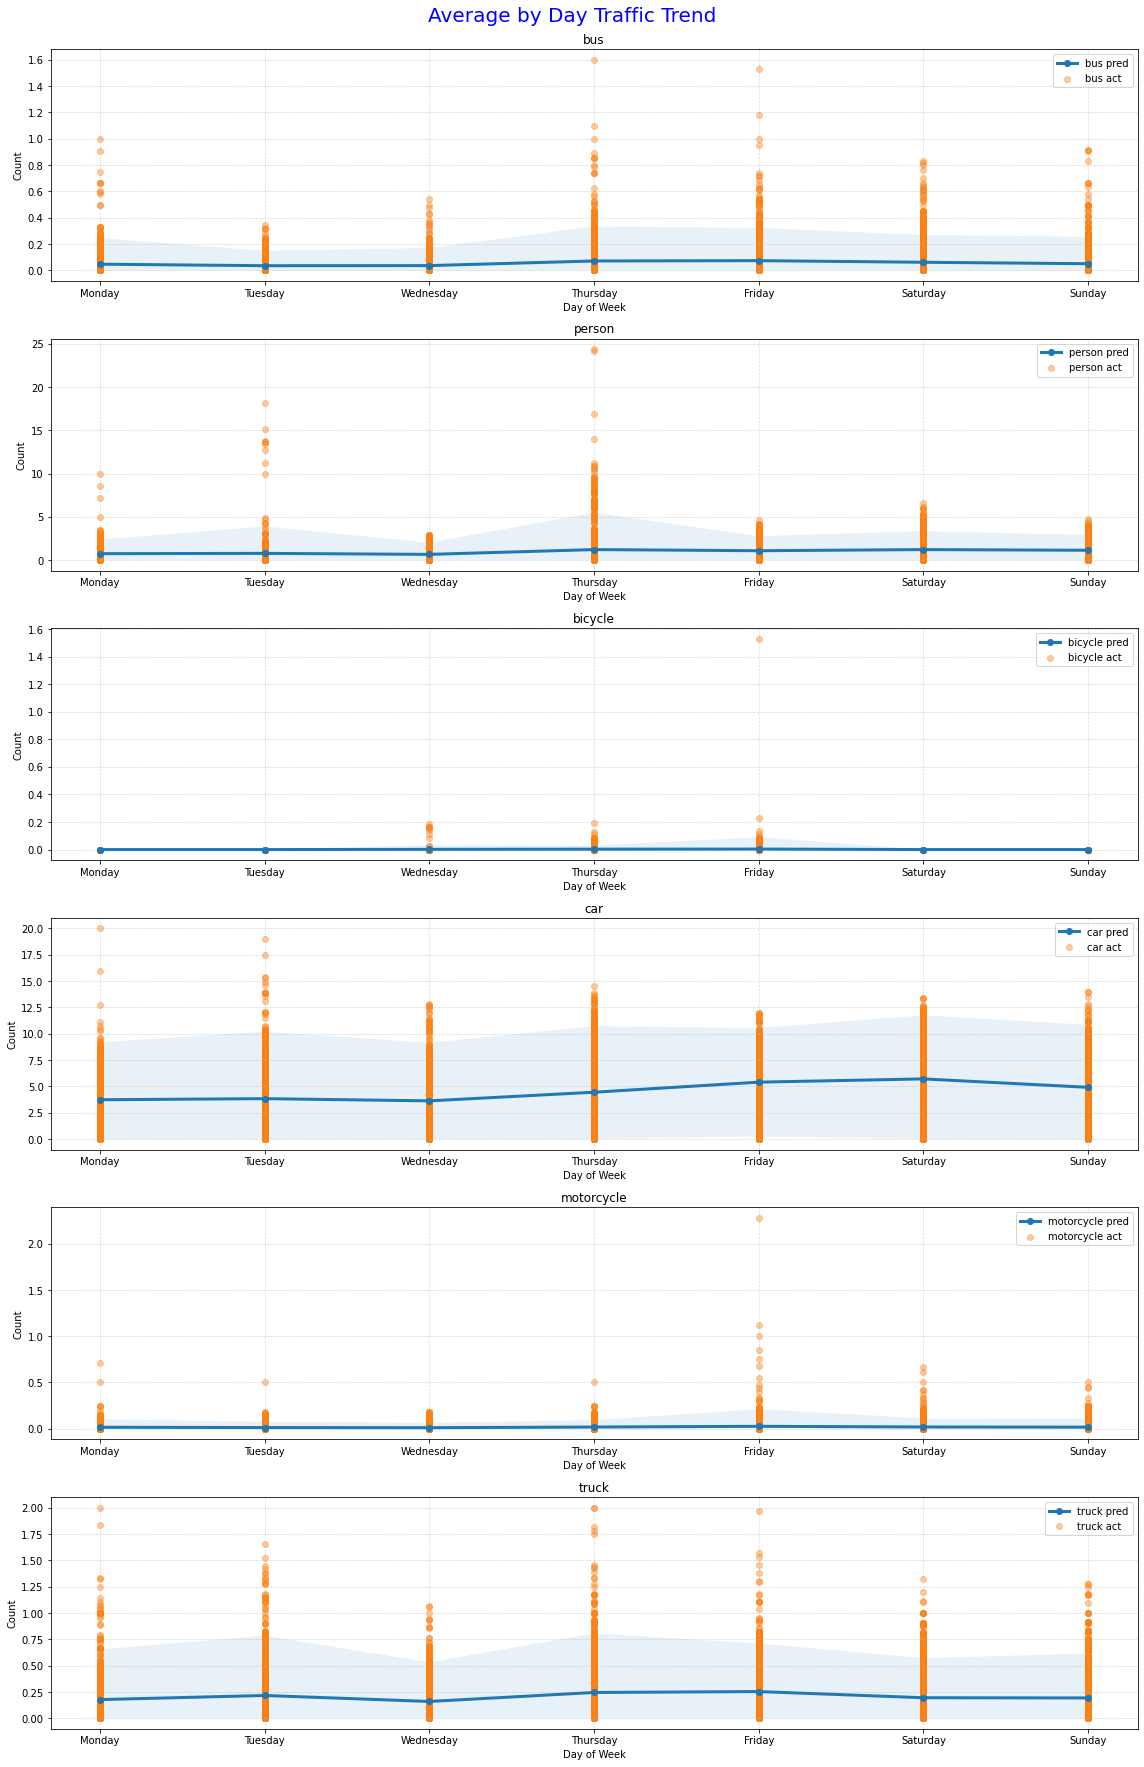

In [461]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Day Traffic Trend\n", fontsize=20, c='b')

plot_df = weekdayavg_df

for i, c in enumerate(categories):
    if len(plot_df[c]) == 0:
        continue
    y_val = plot_df[(c, 'mean')]
    y_err = plot_df[(c, 'std')].values * 1.97
    subplot[i].plot(plot_df.index, y_val, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(plot_df.index, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.1)
    subplot[i].scatter(raw_df.weekday, raw_df[c], alpha=.4, label=f"{c} act", s=3)

    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Day of Week")
    tick_locations = range(0,7)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

Measure accuracy

In [452]:
# extract the mean columns for each class
for c in categories:
    weekdayavg_df[f"{c}_pred"] = weekdayavg_df[(c, 'mean')]
weekdayavg_df = weekdayavg_df.droplevel(1, axis=1).drop(columns=categories)
weekdayavg_df = weekdayavg_df.reset_index()

weekdayavg_accuracy = raw_df.merge(weekdayavg_df, on='weekday')

results_dict.update(results(weekdayavg_accuracy, "WeekdayAvg"))

Scores by Cateogry
	Class                  R2  Root MSE
	bus                 0.016     0.106
	person              0.027     1.232
	bicycle             0.006     0.019
	car                 0.066      2.96
	motorcycle          0.006     0.054
	truck               0.017     0.231


<h1>Predict by Time of Day</h1>
Predict based on the time of day.

In [462]:
dayavg_df = raw_df.groupby(['day_minute_qtr_hour']).agg([np.mean, np.std])[categories]
dayavg_df['time_stamp'] = pd.Series(dayavg_df.index.values).apply(lambda s: datetime.time(int(s/60),s%60)).values
dayavg_df.reset_index(inplace=True)
dayavg_df.head()

day_minute_qtr_hour       bus              person           bicycle       \
                           mean       std      mean       std    mean  std   
0                   0  0.000000  0.000000  0.078558  0.083620     0.0  0.0   
1                  15  0.001078  0.005653  0.076196  0.133481     0.0  0.0   
2                  30  0.000735  0.005143  0.092184  0.146719     0.0  0.0   
3                  45  0.000680  0.004808  0.085720  0.101167     0.0  0.0   
4                  60  0.000756  0.005068  0.118467  0.177349     0.0  0.0   

        car           motorcycle               truck           time_stamp  
       mean       std       mean       std      mean       std             
0  0.289904  0.487433   0.000000  0.000000  0.011942  0.020902   00:00:00  
1  0.248255  0.494880   0.000000  0.000000  0.012118  0.023321   00:15:00  
2  0.345082  0.527704   0.000000  0.000000  0.011633  0.022947   00:30:00  
3  0.221260  0.481677   0.001440  0.007126  0.005300  0.018640   00:45:00  
4  0.221600  0.517871   0.000756  0.005068  0.004244  0.012403   01:00:00

In [465]:
len(raw_df.day_minute_qtr_hour.unique())

96

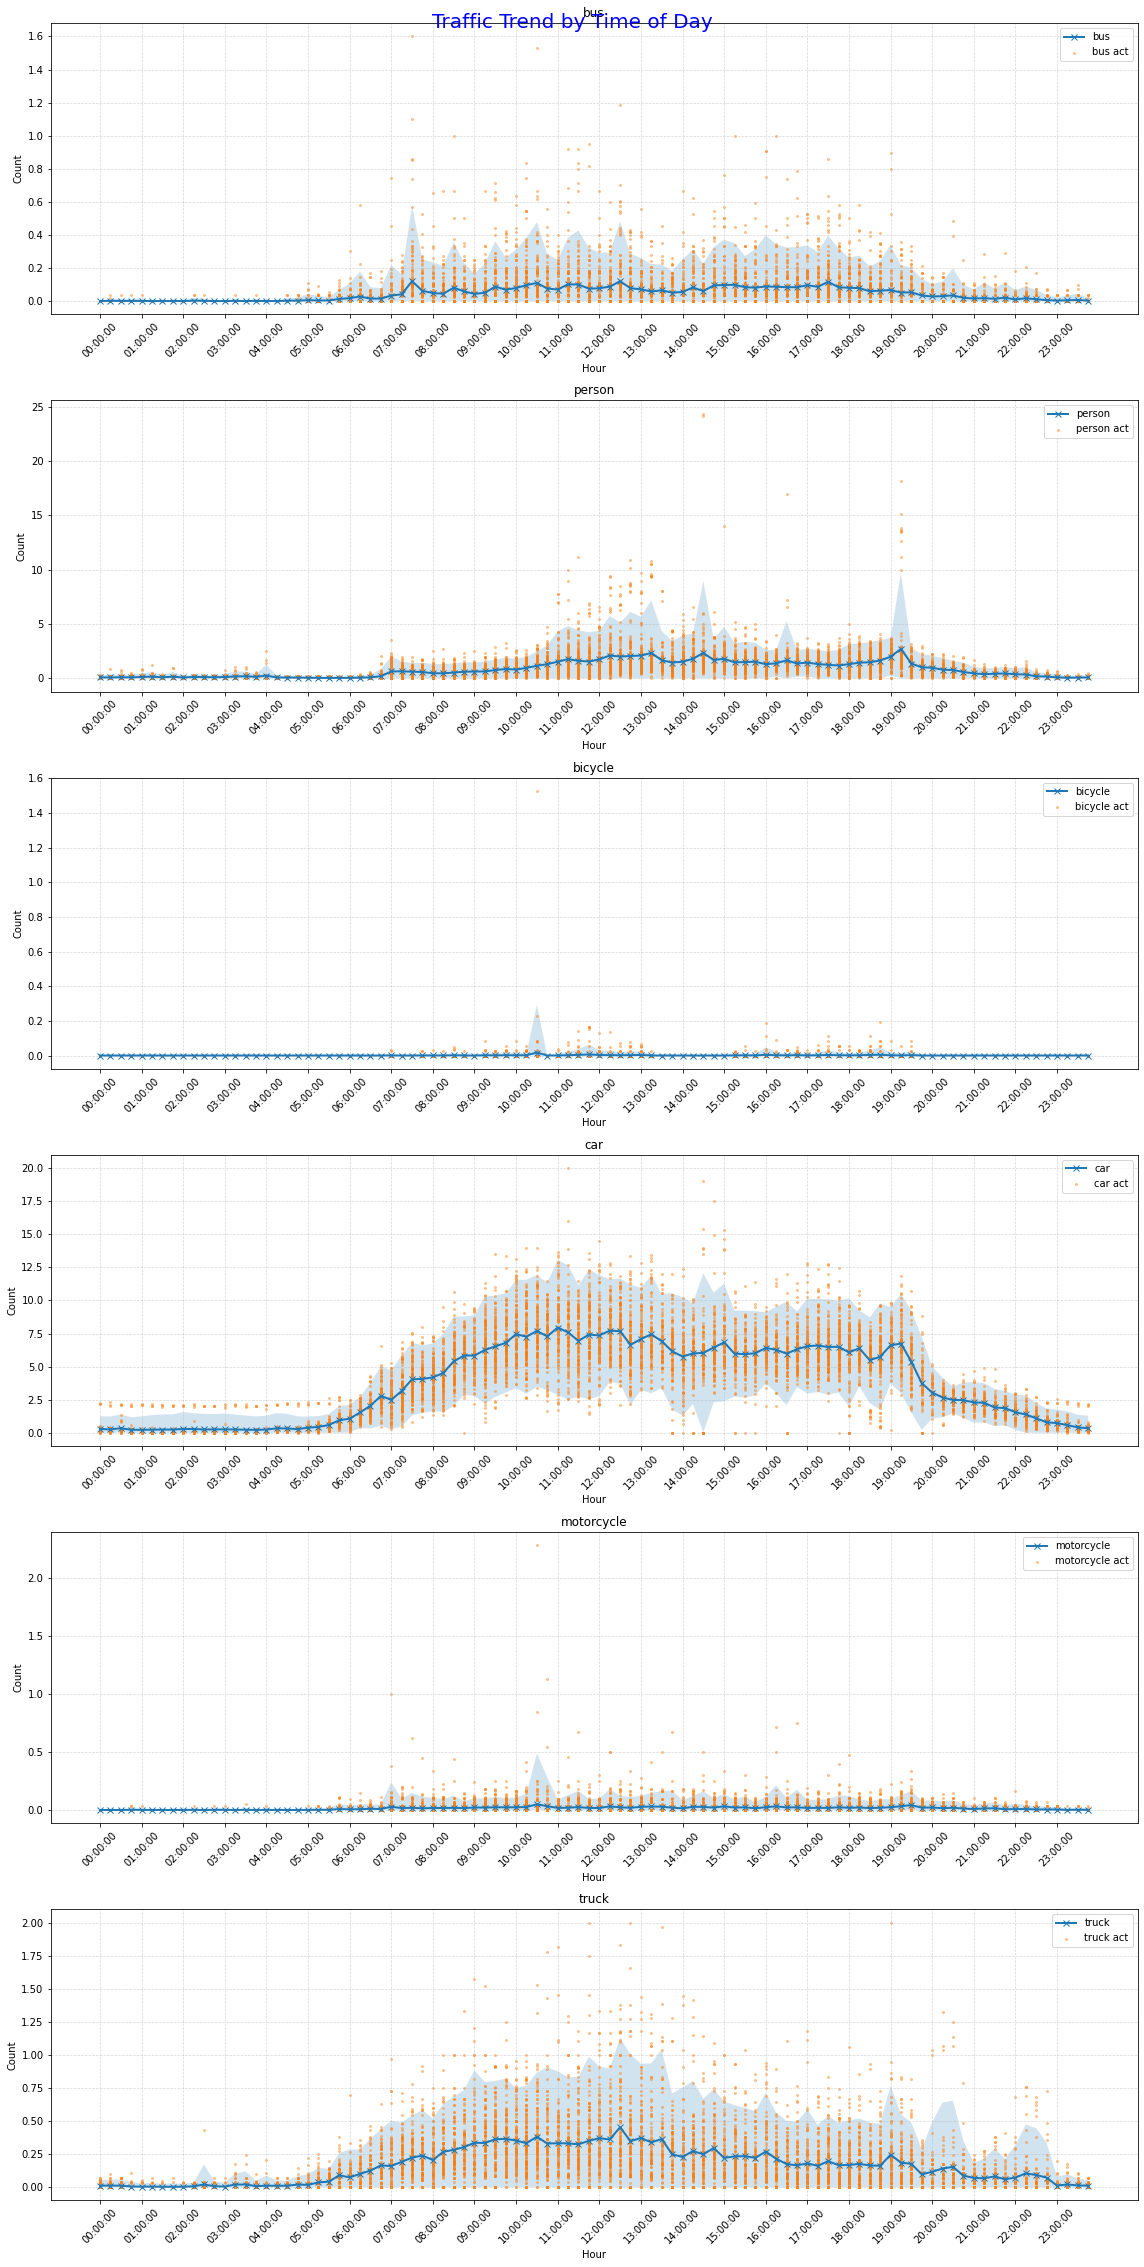

In [489]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,32))
fig.suptitle("Traffic Trend by Time of Day", fontsize=20, c='b')

plot_df = dayavg_df

for i, c in enumerate(categories):
    if len(plot_df[c]) == 0:
        continue
    y_val = plot_df[(c, 'mean')]
    y_err = plot_df[(c, 'std')].values * 1.97
    subplot[i].plot(plot_df.day_minute_qtr_hour, y_val, label=c, marker='x', lw=2)
    subplot[i].fill_between(plot_df.day_minute_qtr_hour, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.2)
    subplot[i].scatter(raw_df.day_minute_qtr_hour, raw_df[c], alpha=.4, label=f"{c} act", s=4)

    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Hour")
    tick_locations = [x for i, x in enumerate(dayavg_df.day_minute_qtr_hour) if i%4==0]
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(plot_df.time_stamp[np.array(tick_locations)/15], rotation=45)

    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()

plt.tight_layout()
plt.show()

If we use the overall average value for each 15min segment of the day as our model, we calculate the accuracy:

In [490]:
# extract the mean columns for each class
for c in categories:
    dayavg_df[f"{c}_pred"] = dayavg_df[(c, 'mean')]
dayavg_df = dayavg_df.droplevel(1, axis=1).drop(columns=categories)

dayavg_accuracy = raw_df.merge(dayavg_df, on='day_minute_qtr_hour')

results_dict.update(results(dayavg_accuracy, "TimeOfDayAverage"))

Scores by Cateogry
	Class                  R2  Root MSE
	bus                 0.108     0.101
	person              0.305     1.041
	bicycle             0.015     0.019
	car                 0.702     1.671
	motorcycle          0.035     0.053
	truck               0.266       0.2


<h1>Predict by Time of Day and Day of Week</h1>
Use the time of the day and the day of the week.

In [491]:
weekdayavg_QTRHR_df = raw_df.groupby(['week_minute_qtr_hour', 'weekday']).agg([np.mean, np.std])[categories]
weekdayavg_QTRHR_df['weekday'] = weekdayavg_QTRHR_df.index.get_level_values(1)
weekdayavg_QTRHR_df.set_index(weekdayavg_QTRHR_df.index.get_level_values(0), inplace=True)
weekdayavg_QTRHR_df['newday'] = weekdayavg_QTRHR_df['weekday'].diff().astype(bool) # True is first entry for new day

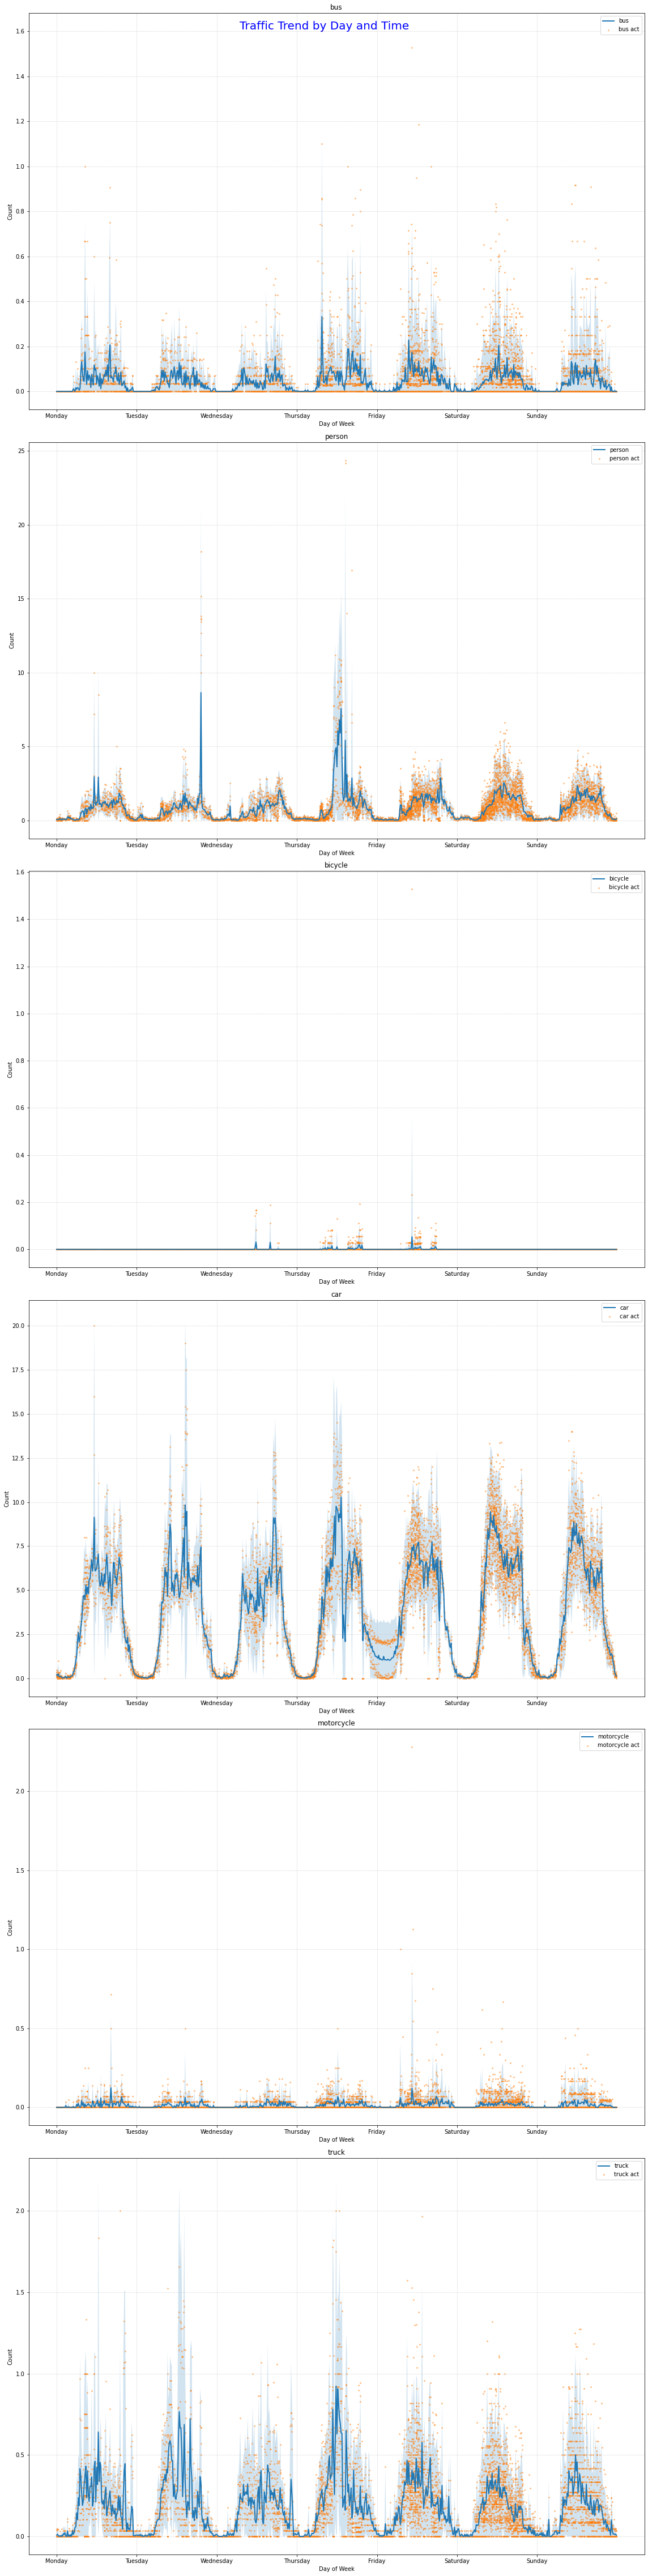

In [495]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,64))
fig.suptitle("Traffic Trend by Day and Time\n", fontsize=20, c='b')

plot_df = weekdayavg_QTRHR_df

for i, c in enumerate(categories):
    if len(plot_df[c]) == 0:
        continue
    y_val = plot_df[(c, 'mean')]
    y_err = plot_df[(c, 'std')].values * 1.97
    subplot[i].plot(plot_df.index, y_val, label=c, lw=2)
    subplot[i].fill_between(plot_df.index, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.2)    
    subplot[i].scatter(raw_df.week_minute_qtr_hour, raw_df[c], alpha=.4, label=f"{c} act", s=4)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Day of Week")
    tick_locations = weekdayavg_QTRHR_df[weekdayavg_QTRHR_df['newday'] == True].index
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()

plt.tight_layout()
plt.show()

Measure Accuracy

In [496]:
# extract the mean columns for each class
for c in categories:
    weekdayavg_QTRHR_df[f"{c}_pred"] = weekdayavg_QTRHR_df[(c, 'mean')]
weekdayavg_QTRHR_df = weekdayavg_QTRHR_df.droplevel(1, axis=1).drop(columns=categories)
weekdayavg_QTRHR_df = weekdayavg_QTRHR_df.reset_index()
weekdayavg_QTRHR_df_accuracy = raw_df.merge(weekdayavg_QTRHR_df, on='week_minute_qtr_hour')

results_dict.update(results(weekdayavg_QTRHR_df_accuracy, "DayAndTimeAvg"))

Scores by Cateogry
	Class                  R2  Root MSE
	bus                 0.197     0.096
	person              0.536     0.851
	bicycle              0.06     0.019
	car                 0.793     1.392
	motorcycle           0.09     0.052
	truck               0.394     0.181


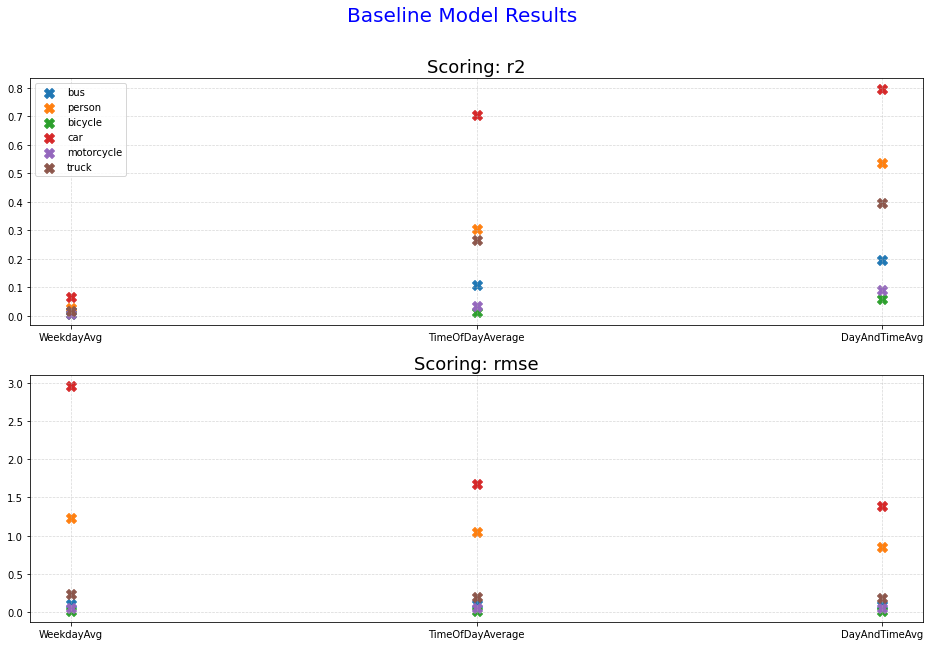

In [497]:
scores = ['r2', 'rmse']

fig, subplot = plt.subplots(nrows=len(scores), ncols=1, figsize=(16,10))
fig.suptitle("Baseline Model Results", fontsize=20, c='b')

x_axis = list(results_dict.keys())

for i, score in enumerate(scores):

    plot_df = pd.DataFrame(results_dict).apply(lambda s: [s1.get(score) for s1 in s], axis=1)

    subplot[i].set_title(f"Scoring: {score}", fontsize=18)
    for c in plot_df.index:
        subplot[i].scatter(x_axis, plot_df.loc[c], label=c, marker='X', s=100)

    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    if i == 0:
        subplot[i].legend()

plt.show()


<h1>Baseline Model Results</h1>

<b>Weekday Average</b> <br>
This is the worst performing model and is no surprise.  Here, we predict the observation rate based on the overall average of each day of the week.  This will take into account that some days are busier than others, but does not consider the time of day when making prdictions.

<b>Time of Day</b> <br>
Making predictions based on the time of the day yields better results.  Here, we consider the time of the day, but not the day of the week.

<b>Day and Time</b> <br>
Lastly, we use both the day of the week and the time of the day to make prdictions.  Both the R2 and MSE scores improve which makes sense and is expected.  We will consider this our baseline model.

<h1>Model Design</h1> <br>
To improve on the baseline, we need to consider the previous trend.  Doing so would reflect things like seasonality, weather or special events.  For example, if Monday is slow, we may be able to expect that Tuesday is slow or if things are slow at 9am, they may also be slow at 3pm.  This will not take holidays into effect, so we may want to add holidays to the source data.

Our final objective is to predict the next day's traffic pattern at the end of each day.

<b>Step 1: Predict the next 15min rate.</b> <br>
- Use previous observations to record the next 15 minute interval as a single point.

<b>Step 2: Predict the next hour in 15min increments</b> <br>
- Predict several points in the future.

<b>Step 3: Explore other models</b> <br>
- Remove the poorest performing models from the mix.  Identify other models that may make up for shortcomings of selected models.

<b>Step 4: Finalize Models</b> <br>
- Determine best final model or combination of models to use as the final design.


<b>Step 5: Build prediction programs and incorporate into final product</b> <br>
- Revise the charting service in the monitor application to reflect preductions.
- Include the current accuracy of the model and update it dynamically.
- Build aplication so that at the end of each day, the models are refit with the new model data and predictions for the next day are built and charted.


<h2>Feature Engineering</h2> <br>

- Each 15minute increment will be predicted based on the previous 24hrs of 15min increments.
- For each observation, we will create a column for each 15min observation of the previous 24 hours

In [21]:
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday,month,day,year,qtr_hour,hour,minute,day_minute,day_minute_qtr_hour,week_minute,week_minute_qtr_hour,midnight
time_stamp,,,,,,,,,,,,,,,,,,
2020-08-28 13:59:46.557975,0.0,0.000,3.308,0.0,0.231,0.0,4,8,28,2020,45,13,59,839,825,6599,6585,False
2020-08-28 14:00:46.711236,0.0,0.000,3.417,0.0,0.833,0.0,4,8,28,2020,0,14,0,840,840,6600,6600,False
2020-08-28 14:01:46.725153,0.0,0.000,3.000,0.0,0.333,0.0,4,8,28,2020,0,14,1,841,840,6601,6600,False
2020-08-28 14:02:46.745504,0.0,0.083,2.333,0.0,0.083,0.0,4,8,28,2020,0,14,2,842,840,6602,6600,False
2020-08-28 14:03:46.762111,0.0,0.083,4.667,0.0,0.333,0.0,4,8,28,2020,0,14,3,843,840,6603,6600,False


In [ ]:
# group the table into 15min increments

In [499]:
rs = LogEntry.objects.all().values()
raw_df = pd.DataFrame(rs)

# convert to local TZ and then remove the timezone from the time_stamp
raw_df['time_stamp'] = raw_df['time_stamp'].dt.tz_convert(pytz.timezone('US/Mountain')).dt.tz_localize(None)

# save the categories
categories = raw_df['class_name'].unique()
remove_categories = ['traffic light', 'dog', 'umbrella']
categories = list(set(categories).difference(set(remove_categories)))

raw_df = raw_df[raw_df.class_name.isin(categories)]
raw_df.head()

,key,time_stamp,monitor_id,class_name,count
0,33,2020-08-28 13:59:46.557975,MyMonitor,car,3.308
1,34,2020-08-28 13:59:46.557975,MyMonitor,person,0.231
2,35,2020-08-28 14:00:46.711236,MyMonitor,car,3.417
3,36,2020-08-28 14:00:46.711236,MyMonitor,person,0.833
4,37,2020-08-28 14:01:46.725153,MyMonitor,car,3.000


In [500]:
raw_df = raw_df.pivot_table(index=['time_stamp'], columns='class_name', values='count', fill_value=0)
raw_df.columns = raw_df.columns.get_level_values(0).values
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck
time_stamp,,,,,,
2020-08-28 13:59:46.557975,0.0,0.000,3.308,0.0,0.231,0.0
2020-08-28 14:00:46.711236,0.0,0.000,3.417,0.0,0.833,0.0
2020-08-28 14:01:46.725153,0.0,0.000,3.000,0.0,0.333,0.0
2020-08-28 14:02:46.745504,0.0,0.083,2.333,0.0,0.083,0.0
2020-08-28 14:03:46.762111,0.0,0.083,4.667,0.0,0.333,0.0


In [501]:
raw_df['year'] = pd.Series(raw_df.index).apply(lambda s: s.year).values
raw_df['month'] = pd.Series(raw_df.index).apply(lambda s: s.month).values
raw_df['weekday'] = pd.Series(raw_df.index).apply(lambda s: s.weekday()).values
raw_df['day'] = pd.Series(raw_df.index).apply(lambda s: s.day).values
raw_df['hour'] = pd.Series(raw_df.index).apply(lambda s: s.hour).values
raw_df['qtr_hour'] = pd.Series(raw_df.index).apply(lambda s : int(s.minute / 15) * 15).values
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,year,month,weekday,day,hour,qtr_hour
time_stamp,,,,,,,,,,,,
2020-08-28 13:59:46.557975,0.0,0.000,3.308,0.0,0.231,0.0,2020,8,4,28,13,45
2020-08-28 14:00:46.711236,0.0,0.000,3.417,0.0,0.833,0.0,2020,8,4,28,14,0
2020-08-28 14:01:46.725153,0.0,0.000,3.000,0.0,0.333,0.0,2020,8,4,28,14,0
2020-08-28 14:02:46.745504,0.0,0.083,2.333,0.0,0.083,0.0,2020,8,4,28,14,0
2020-08-28 14:03:46.762111,0.0,0.083,4.667,0.0,0.333,0.0,2020,8,4,28,14,0


In [502]:
raw_df = raw_df.groupby(['year','month','day','hour', 'qtr_hour']).mean()
# reconfigure index to a timestamp
raw_df.set_index(pd.Series(list(raw_df.index)).apply(lambda s: datetime.datetime(*s)), inplace=True)
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday
2020-08-28 13:45:00,0.0,0.000000,3.308000,0.0,0.231000,0.0,4
2020-08-28 14:00:00,0.0,0.031357,3.425214,0.0,0.257571,0.0,4
2020-08-28 14:15:00,0.0,0.000000,3.164400,0.0,0.061600,0.0,4
2020-08-29 04:45:00,0.0,0.000000,0.224667,0.0,0.000000,0.0,5
2020-08-29 05:00:00,0.0,0.000000,0.250000,0.0,0.000000,0.0,5


In [503]:
# limit the data source to dates starting 9/26/2020
start_time = pd.Timestamp(datetime.datetime(2020,9,26,7))
raw_df = raw_df[raw_df.index >= start_time]

In [504]:
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday
2020-09-26 07:00:00,0.0,0.000,5.250000,0.375000,0.000000,0.125000,5
2020-09-26 07:45:00,0.0,0.082,4.044000,0.000000,0.586000,0.087500,5
2020-09-26 08:00:00,0.0,0.018,5.029667,0.000000,0.565667,0.155000,5
2020-09-26 08:15:00,0.0,0.012,6.399000,0.006333,0.660000,0.143000,5
2020-09-26 08:30:00,0.0,0.011,6.823667,0.011333,0.758000,0.226667,5


In [505]:
# make every 15minute increment exist whether there are observations or not.
end_time = raw_df.index.max()

In [506]:
t = start_time
rv =[]
while t < end_time:
    t = t + pd.Timedelta('15 minutes')
    rv.append(t)
len(rv), len(raw_df)

(1285, 1158)

In [507]:
# for each category, we create colums for each previous time period

In [508]:
raw_df = pd.DataFrame(index=rv).join(raw_df, how='outer')
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday
2020-09-26 07:00:00,0.0,0.000,5.250000,0.375,0.000000,0.1250,5.0
2020-09-26 07:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-26 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-26 07:45:00,0.0,0.082,4.044000,0.000,0.586000,0.0875,5.0
2020-09-26 08:00:00,0.0,0.018,5.029667,0.000,0.565667,0.1550,5.0


In [509]:
# we will have missingness where observations weren't collected for a time period
# we can fill them by backfilling or forward filling.  We will do a little of both 
# for ffill half the gap and bfill the other half.

In [510]:
# for c in raw_df.columns:
while raw_df.isna().any().any():
    raw_df.fillna(method='ffill', limit=1, inplace=True)
    raw_df.fillna(method='bfill', limit=1, inplace=True)

In [511]:
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday
2020-09-26 07:00:00,0.0,0.000,5.250000,0.375,0.000000,0.1250,5.0
2020-09-26 07:15:00,0.0,0.000,5.250000,0.375,0.000000,0.1250,5.0
2020-09-26 07:30:00,0.0,0.082,4.044000,0.000,0.586000,0.0875,5.0
2020-09-26 07:45:00,0.0,0.082,4.044000,0.000,0.586000,0.0875,5.0
2020-09-26 08:00:00,0.0,0.018,5.029667,0.000,0.565667,0.1550,5.0


In [512]:
for c in categories:
    for s in range(1, shifts+1):
        raw_df[f"{c}_{s}"] = raw_df[c].shift(s)

In [513]:
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday,bus_1,bus_2,bus_3,...,truck_87,truck_88,truck_89,truck_90,truck_91,truck_92,truck_93,truck_94,truck_95,truck_96
2020-09-26 07:00:00,0.0,0.000,5.250000,0.375,0.000000,0.1250,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-26 07:15:00,0.0,0.000,5.250000,0.375,0.000000,0.1250,5.0,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-26 07:30:00,0.0,0.082,4.044000,0.000,0.586000,0.0875,5.0,0.000,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-26 07:45:00,0.0,0.082,4.044000,0.000,0.586000,0.0875,5.0,0.082,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-26 08:00:00,0.0,0.018,5.029667,0.000,0.565667,0.1550,5.0,0.082,0.082,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [514]:
# now remove the first number of elements that we shifted because they will have NA in the shifted columns
# This represents the need to have a day of observations before we can make a prediction
raw_df = raw_df.iloc[shifts:]

In [515]:
raw_df.isna().any().any()

False

In [516]:
raw_df.head()

,bicycle,bus,car,motorcycle,person,truck,weekday,bus_1,bus_2,bus_3,...,truck_87,truck_88,truck_89,truck_90,truck_91,truck_92,truck_93,truck_94,truck_95,truck_96
2020-09-27 07:00:00,0.0,0.012000,4.465333,0.000000,0.047667,0.012000,6.0,0.000000,0.000000,0.000000,...,0.349333,0.196000,0.210333,0.226667,0.143000,0.155000,0.087500,0.087500,0.1250,0.1250
2020-09-27 07:15:00,0.0,0.059667,3.951333,0.011333,0.103667,0.081000,6.0,0.012000,0.000000,0.000000,...,0.271000,0.349333,0.196000,0.210333,0.226667,0.143000,0.155000,0.087500,0.0875,0.1250
2020-09-27 07:30:00,0.0,0.094000,2.220667,0.023333,0.129333,0.058333,6.0,0.059667,0.012000,0.000000,...,0.218333,0.271000,0.349333,0.196000,0.210333,0.226667,0.143000,0.155000,0.0875,0.0875
2020-09-27 07:45:00,0.0,0.035000,2.838667,0.000000,0.359667,0.116667,6.0,0.094000,0.059667,0.012000,...,0.289667,0.218333,0.271000,0.349333,0.196000,0.210333,0.226667,0.143000,0.1550,0.0875
2020-09-27 08:00:00,0.0,0.045667,4.046000,0.000000,0.586333,0.114667,6.0,0.035000,0.094000,0.059667,...,0.137000,0.289667,0.218333,0.271000,0.349333,0.196000,0.210333,0.226667,0.1430,0.1550


<h2>Train and Test Sets</h2>

In [366]:
class_name = 'person'
X_train = raw_df[[c for c in raw_df.columns if c.startswith(f"{class_name}_")]]
y_train = raw_df[class_name]

In [367]:
_models = []
_models.append(('LR', LinearRegression()))
# _models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
_models.append(('KNN', KNeighborsRegressor(n_neighbors=shifts))) 
_models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
_models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

LR: 0.730482 (0.213871)
KNN: 0.584111 (0.250109)
RF: 0.708663 (0.173996)
SVR: 0.740014 (0.174385)


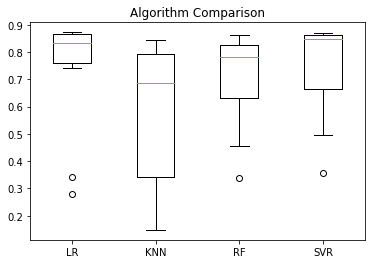

In [368]:
# Evaluate each model in turn
results = []
names = []
for name, model in _models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [369]:
# Grid Search for better parameters
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print(best_score)

0.7595219293748781


In [370]:
best_model.max_features

'auto'

In [371]:
best_model.n_estimators

100

In [372]:
best_model.max_depth

13

In [373]:
gsearch.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [374]:
gsearch.cv_results_.get('rank_test_score')

array([23,  5, 19, 86, 62, 47, 65, 80, 70,  3, 16, 11, 79, 31, 50, 84, 66,
       76, 29,  6, 14, 57, 30, 33, 68, 64, 51, 25, 17,  2, 55, 77, 44, 61,
       39, 71, 24, 12, 15, 56, 59, 41, 63, 82, 73, 18, 10, 20, 38, 35, 34,
       89, 69, 67, 27, 26, 13, 87, 36, 45, 88, 58, 52, 49, 21,  7, 74, 40,
       28, 85, 72, 48, 60,  8,  1, 78, 43, 37, 83, 75, 54,  9,  4, 22, 81,
       42, 32, 90, 53, 46], dtype=int32)

In [375]:
gsearch.cv_results_.get('mean_test_score')

array([0.74782721, 0.75483422, 0.75041879, 0.70640934, 0.72006277,
       0.72787842, 0.71971245, 0.71061169, 0.71785333, 0.75782009,
       0.75082309, 0.75188797, 0.71103239, 0.73463752, 0.72651722,
       0.70739924, 0.71882717, 0.71330844, 0.7399419 , 0.75477518,
       0.75101071, 0.72280947, 0.73990641, 0.73439952, 0.71831033,
       0.71985895, 0.72631046, 0.74658569, 0.75059294, 0.75845989,
       0.7239288 , 0.71291081, 0.7297022 , 0.72026059, 0.73221194,
       0.71750229, 0.74685952, 0.75171368, 0.75086376, 0.72320076,
       0.72110411, 0.73034195, 0.71999469, 0.70946728, 0.71499014,
       0.7505059 , 0.75192393, 0.75020212, 0.73247151, 0.73313664,
       0.73373209, 0.69614115, 0.71820818, 0.71868478, 0.74393555,
       0.7446702 , 0.75112453, 0.70486809, 0.7330581 , 0.72906466,
       0.70001416, 0.72221905, 0.72585517, 0.72709431, 0.7486633 ,
       0.75449037, 0.71428192, 0.73061333, 0.74065986, 0.70719472,
       0.71690251, 0.72751171, 0.72070328, 0.75404067, 0.75952

In [376]:
gs_results_df = pd.DataFrame(gsearch.cv_results_).sort_values(by='rank_test_score', ascending=False).reset_index()

In [377]:
gs_results_df

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,87,0.040531,0.013411,0.003180,0.000076,14,log2,20,"{'max_depth': 14, 'max_features': 'log2', 'n_e...",0.347804,...,0.723323,0.855284,0.864954,0.807318,0.829906,0.846487,0.791157,0.691814,0.199238,90
1,51,0.037132,0.010868,0.003090,0.000078,10,log2,20,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.344492,...,0.765199,0.865910,0.842276,0.800681,0.858643,0.840749,0.842284,0.696141,0.208817,89
2,60,0.038353,0.011602,0.003187,0.000166,11,log2,20,"{'max_depth': 11, 'max_features': 'log2', 'n_e...",0.448370,...,0.795989,0.855967,0.843779,0.764504,0.831814,0.852508,0.809729,0.700014,0.191887,88
3,57,0.049755,0.020212,0.003735,0.001694,11,sqrt,20,"{'max_depth': 11, 'max_features': 'sqrt', 'n_e...",0.369924,...,0.761668,0.862471,0.853751,0.810777,0.838769,0.845271,0.829479,0.704868,0.193938,87
4,3,0.034042,0.008615,0.003026,0.000105,5,sqrt,20,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.565388,...,0.772128,0.857312,0.858387,0.776202,0.834475,0.851116,0.812896,0.706409,0.188454,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1,0.418566,0.218802,0.004855,0.000641,5,auto,50,"{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.564629,...,0.811208,0.834106,0.857727,0.779207,0.842762,0.854822,0.863161,0.754834,0.126095,5
86,82,0.747406,0.447062,0.005001,0.000321,14,auto,50,"{'max_depth': 14, 'max_features': 'auto', 'n_e...",0.562869,...,0.822457,0.814807,0.868846,0.789993,0.865093,0.865123,0.854541,0.757473,0.131676,4
87,9,0.195475,0.105508,0.003109,0.000063,6,auto,20,"{'max_depth': 6, 'max_features': 'auto', 'n_es...",0.608129,...,0.793085,0.836647,0.852426,0.773904,0.852893,0.859145,0.854852,0.757820,0.124730,3
88,29,1.183476,0.661146,0.007384,0.000237,8,auto,100,"{'max_depth': 8, 'max_features': 'auto', 'n_es...",0.557426,...,0.819266,0.830944,0.863058,0.791425,0.854538,0.856808,0.871761,0.758460,0.129117,2


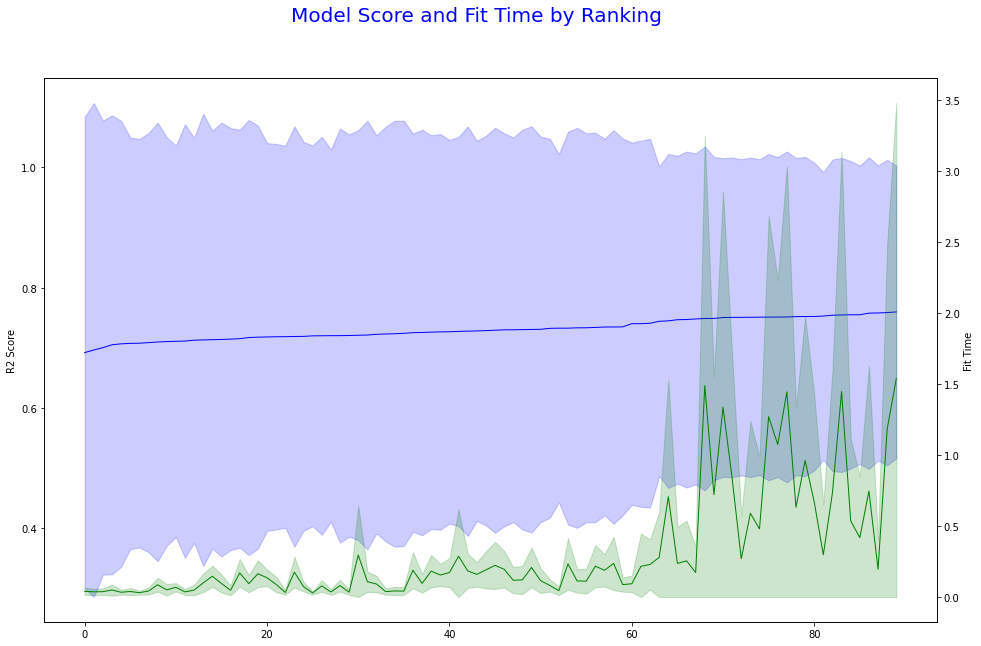

In [378]:
fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
fig.suptitle("Model Score and Fit Time by Ranking", fontsize=20, c='b')

plot_df = gs_results_df

['mean_fit_time', 'param_max_depth', 'param_n_estimators', 'mean_test_score']

y_val = plot_df['mean_test_score']
y_err = plot_df['std_test_score'].values * 1.97
subplot.plot(plot_df.index, y_val, label=c, lw=1, color='blue')
subplot.fill_between(plot_df.index, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.2, color='blue')

# subplot.set_title("MyMonitor")
subplot.set_ylabel("R2 Score")
# subplot.set_xlabel("Ranking")
# subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
# subplot.legend()

subplot = subplot.twinx()
y_val = plot_df['mean_fit_time']
y_err = plot_df['std_fit_time'].values * 1.97
subplot.plot(plot_df.index, y_val, label=c, lw=1, color='green')
subplot.fill_between(plot_df.index, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.2, color='green')
subplot.set_ylabel("Fit Time")



plt.show()

Better scoring models take longer to fit; however, at the 70th, model, we see a drop in time at a point where the R2 score ceases to improve much.

Let's analyze the models from 60 onwards

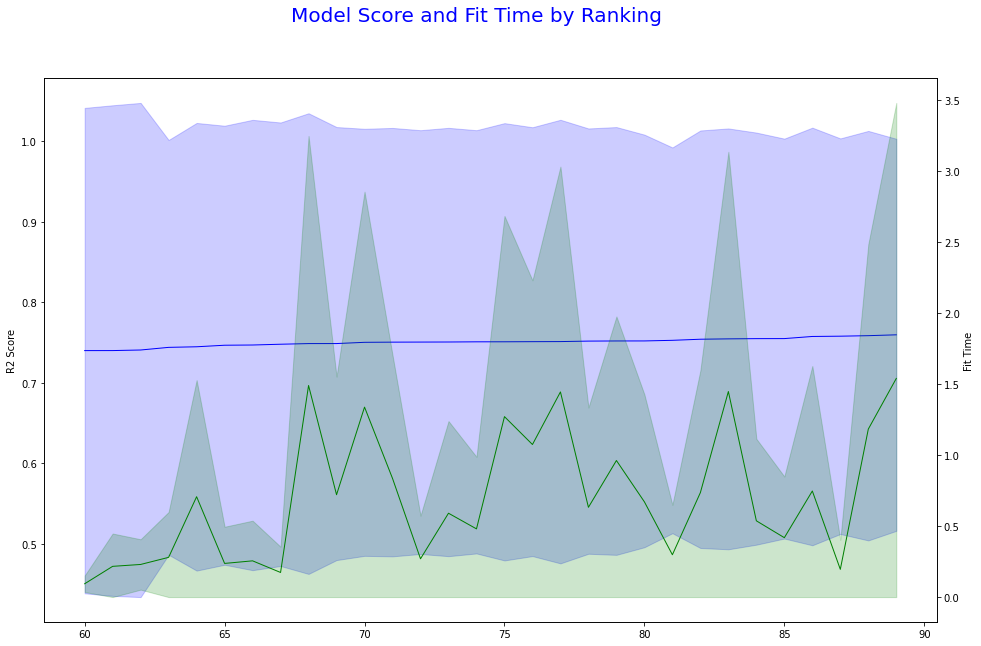

In [379]:
fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
fig.suptitle("Model Score and Fit Time by Ranking", fontsize=20, c='b')

plot_df = gs_results_df[60:]

['mean_fit_time', 'param_max_depth', 'param_n_estimators', 'mean_test_score']

y_val = plot_df['mean_test_score']
y_err = plot_df['std_test_score'].values * 1.97
subplot.plot(plot_df.index, y_val, label=c, lw=1, color='blue')
subplot.fill_between(plot_df.index, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.2, color='blue')

# subplot.set_title("MyMonitor")
subplot.set_ylabel("R2 Score")
# subplot.set_xlabel("Ranking")
# subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
# subplot.legend()

subplot = subplot.twinx()
y_val = plot_df['mean_fit_time']
y_err = plot_df['std_fit_time'].values * 1.97
subplot.plot(plot_df.index, y_val, label=c, lw=1, color='green')
subplot.fill_between(plot_df.index, np.clip(y_val - y_err,a_min=0, a_max=None), y_val + y_err, alpha=0.2, color='green')
subplot.set_ylabel("Fit Time")



plt.show()

The models between 65 and 75 have high scores and faster performance.  Let's review them.

In [380]:
gs_results_df[65:75]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
65,27,0.237186,0.131153,0.003148,0.000103,8,auto,20,"{'max_depth': 8, 'max_features': 'auto', 'n_es...",0.540836,...,0.778054,0.833442,0.855592,0.777160,0.857115,0.867930,0.867088,0.746586,0.138429,25
66,36,0.255380,0.143582,0.003166,0.000095,9,auto,20,"{'max_depth': 9, 'max_features': 'auto', 'n_es...",0.481784,...,0.834840,0.802596,0.847025,0.808735,0.847351,0.853204,0.859951,0.746860,0.141992,24
67,0,0.173423,0.092141,0.003106,0.000060,5,auto,20,"{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.477851,...,0.812971,0.814865,0.866955,0.788283,0.849949,0.843578,0.865140,0.747827,0.139834,23
68,83,1.490551,0.892513,0.007830,0.000407,14,auto,100,"{'max_depth': 14, 'max_features': 'auto', 'n_e...",0.468298,...,0.819657,0.839015,0.860210,0.780229,0.854028,0.869172,0.859014,0.748628,0.145250,22
69,64,0.721135,0.422409,0.005373,0.001190,12,auto,50,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.518839,...,0.810358,0.827656,0.868522,0.786161,0.844595,0.863597,0.854061,0.748663,0.136537,21
70,47,1.338335,0.770369,0.007583,0.000240,10,auto,100,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.528405,...,0.820857,0.819235,0.871365,0.780752,0.837171,0.859560,0.865160,0.750202,0.134656,20
71,2,0.835981,0.441095,0.007143,0.000363,5,auto,100,"{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.536129,...,0.816258,0.822958,0.862801,0.793821,0.848339,0.857494,0.857269,0.750419,0.135084,19
72,45,0.269775,0.154257,0.003235,0.000115,10,auto,20,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.480655,...,0.804757,0.832497,0.860498,0.798956,0.844191,0.858035,0.839364,0.750506,0.133619,18
73,28,0.590869,0.329442,0.004671,0.000100,8,auto,50,"{'max_depth': 8, 'max_features': 'auto', 'n_es...",0.558169,...,0.818782,0.833884,0.864838,0.773287,0.850244,0.856191,0.863349,0.750593,0.135055,17
74,10,0.480516,0.257761,0.004583,0.000103,6,auto,50,"{'max_depth': 6, 'max_features': 'auto', 'n_es...",0.547696,...,0.806499,0.818290,0.860553,0.786342,0.848950,0.862196,0.872716,0.750823,0.133451,16


Model 72 is the fastest.  We will choose this one.  Others may have better scores, but not by a significant amount.

In [381]:
best_params = gs_results_df.iloc[72].params
best_params

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}

In [520]:
rf_best = RandomForestRegressor(**best_params).fit(X_train, y_train)

In [522]:
y_pred = rf_best.predict(X_train)

In [523]:
y_pred

array([0.18822241, 0.14462764, 0.11572095, ..., 1.49719201, 1.43608193,
       1.1058006 ])